In [3]:
"""These are assumed to be ran after the production database is updated"""

import pandas as pd

from mainnet_launch.database.postgres_operations import (
    _exec_sql_and_cache,
    get_full_table_as_df_with_tx_hash,
    get_full_table_as_df_with_block,
    ENGINE,
    get_full_table_as_df,
)
from mainnet_launch.database.schema.full import *

from mainnet_launch.slack_messages.post_message import post_slack_message, post_message_with_table
from mainnet_launch.constants import ALL_CHAINS, ALL_AUTOPOOLS

# add destination vault liquidations
# todo simply this to fewer sql queries
ENGINE.echo = False

In [4]:
def fetch_recent_vault_claimed_reward_event_data(n: int) -> pd.DataFrame:

    chain_id_to_name = {c.chain_id: c.name for c in ALL_CHAINS}

    n_days_ago = pd.Timestamp.now() - pd.Timedelta(days=n)

    get_recent_vault_claimed_reward_events_query = f"""

                SELECT
                  claim_vault_rewards.*,
                  destinations.pool as pool,
                  blocks.datetime,
                  blocks.block
              FROM claim_vault_rewards
              JOIN transactions
                ON claim_vault_rewards.tx_hash = transactions.tx_hash
              JOIN blocks
                ON transactions.block = blocks.block
              AND transactions.chain_id = blocks.chain_id
              JOIN destinations
                ON claim_vault_rewards.destination_vault_address = destinations.destination_vault_address
                AND claim_vault_rewards.chain_id = destinations.chain_id
              
              WHERE blocks.datetime > '{n_days_ago}'
              ORDER BY blocks.datetime DESC
  """

    get_recent_autopool_destination_states_query = f"""

              SELECT
                  autopool_destination_states.*,
                  destinations.pool as pool,
                  blocks.datetime
              FROM autopool_destination_states
              JOIN blocks
                ON autopool_destination_states.block = blocks.block
              AND autopool_destination_states.chain_id = blocks.chain_id
              JOIN destinations
                ON autopool_destination_states.destination_vault_address = destinations.destination_vault_address
                AND autopool_destination_states.chain_id = destinations.chain_id

              WHERE blocks.datetime > '{n_days_ago}'
              ORDER BY blocks.datetime DESC
  """

    get_recent_destination_states_query = f"""

          SELECT
          destination_states.*,
          destinations.pool as pool,
          blocks.datetime
          FROM destination_states
          JOIN blocks
          ON destination_states.block = blocks.block
          AND destination_states.chain_id = blocks.chain_id

          JOIN destinations
          ON destination_states.destination_vault_address = destinations.destination_vault_address
          AND destination_states.chain_id = destinations.chain_id

          WHERE blocks.datetime > '{n_days_ago}'
          ORDER BY blocks.datetime DESC           

  """

    claim_vault_rewards = _exec_sql_and_cache(
        get_recent_vault_claimed_reward_events_query,
    )

    autopool_destination_states = _exec_sql_and_cache(
        get_recent_autopool_destination_states_query,
    )

    destination_states = _exec_sql_and_cache(
        get_recent_destination_states_query,
    )
    autopool_destinations = get_full_table_as_df(AutopoolDestinations)
    autopool_destinations["autopool_name"] = autopool_destinations["autopool_vault_address"].map(
        {a.autopool_eth_addr: a.name for a in ALL_AUTOPOOLS}
    )
    destinations = get_full_table_as_df(Destinations)

    # add the highest incentive APR and the most number of owned shares in the period
    destinations["incentive_apr"] = destinations["pool"].map(destination_states.groupby("pool")["incentive_apr"].max())
    destinations["owned_shares"] = destinations["pool"].map(
        autopool_destination_states.groupby("pool")["owned_shares"].max()
    )
    destinations["chain"] = destinations["chain_id"].map(chain_id_to_name)
    return claim_vault_rewards, autopool_destination_states, destination_states, destinations, autopool_destinations


def determine_what_pools_are_missing_rewards_claimed_events(
    claim_vault_rewards: pd.DataFrame, autopool_destination_states: pd.DataFrame, destination_states: pd.DataFrame
) -> set[str]:
    pool_with_recent_claim_rewards = claim_vault_rewards["pool"].unique().tolist()
    pools_with_some_owned_shares = (
        autopool_destination_states[autopool_destination_states["owned_shares"] > 1]["pool"].unique().tolist()
    )
    pools_with_some_incentive_apr = (
        destination_states[destination_states["incentive_apr"] > 0.005]["pool"].unique().tolist()
    )
    pools_with_expected_vault_liquidations = set(pools_with_some_owned_shares) & (set(pools_with_some_incentive_apr))
    pools_missing_vault_liquidations = pools_with_expected_vault_liquidations - set(pool_with_recent_claim_rewards)
    return pools_missing_vault_liquidations


def get_suspect_pools_missing_vault_liquidations():

    claim_vault_rewards, autopool_destination_states, destination_states, destinations, autopool_destinations = (
        fetch_recent_vault_claimed_reward_event_data(n=8)
    )
    all_claim_vault_rewards = claim_vault_rewards.copy()

    pools_missing_vault_liquidations = determine_what_pools_are_missing_rewards_claimed_events(
        claim_vault_rewards, autopool_destination_states, destination_states
    )

    suspect = destinations[destinations["pool"].isin(pools_missing_vault_liquidations)].drop_duplicates("pool").copy()
    suspect_morpho = suspect[suspect["exchange_name"] == "morpho"][
        [
            "destination_vault_address",
            "exchange_name",
            "name",
            "symbol",
            "pool_type",
            "incentive_apr",
            "owned_shares",
            "chain",
        ]
    ]

    claim_vault_rewards, autopool_destination_states, destination_states, destinations, autopool_destinations = (
        fetch_recent_vault_claimed_reward_event_data(n=2)
    )

    pools_missing_vault_liquidations = determine_what_pools_are_missing_rewards_claimed_events(
        claim_vault_rewards, autopool_destination_states, destination_states
    )

    suspect = destinations[destinations["pool"].isin(pools_missing_vault_liquidations)].drop_duplicates("pool").copy()
    suspect_not_morpho = suspect[suspect["exchange_name"] != "morpho"][
        [
            "destination_vault_address",
            "exchange_name",
            "name",
            "symbol",
            "pool_type",
            "incentive_apr",
            "owned_shares",
            "chain",
        ]
    ]

    all_suspect = pd.concat([suspect_morpho, suspect_not_morpho], ignore_index=True)

    return all_suspect, all_claim_vault_rewards, autopool_destinations


all_suspect, all_claim_vault_rewards, autopool_destinations = get_suspect_pools_missing_vault_liquidations()

all_suspect, all_claim_vault_rewards, autopool_destinations

(                     destination_vault_address exchange_name  \
 0   0x4eeDC6d6126ae9C6D92D03bB355eEAe5E47d2b03        morpho   
 1   0xFd70A9b4cE03Dc07Fe7Ba5e4D39fac11eE8d8615        morpho   
 2   0xCc68b840Bd7567363855e1e5050803EC7Ea8C25c        morpho   
 3   0x16cbe611AF0E01ec6988b59aD3690327aD496Eb7        morpho   
 4   0xD7B1F55E0CcfFa849b35aA1c39B94eb415DB00cE        morpho   
 5   0xAC8e9bbEFEAf5971c32E40b9b35DaD0B026a49fa        morpho   
 6   0xab3DA8995D5FeA17913c3D12A5B199F1cCC9Bf0b        morpho   
 7   0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61         fluid   
 8   0x06993Ecd8d8a16204bf7f86B00A0575aB69548DD         fluid   
 9   0x071b90e1e322F5F94F74BA7ADd453BBE8D25032B         fluid   
 10  0x310CCB9eC996A228cd6F4Eb2E70769ccDbeD163D         curve   
 11  0xC253ef426519c700914DA4b2325dD0F4B7E8ffDc    balancerV3   
 
                                            name                       symbol  \
 0          Tokemak-USD Coin-Gauntlet USDC Prime            toke-USDC-gt

In [ ]:
most_recent_vault_claimed_event = all_claim_vault_rewards.groupby("pool")["datetime"].max()

pool_to_most_recent_vault_claimed_event

pool
0x1943FA26360f038230442525Cf1B9125b5DCB401   2025-10-17 18:55:47+00:00
0x19B001e6Bc2d89154c18e2216eec5C8c6047b6d8   2025-10-20 03:37:09+00:00
0x1DD4b13fcAE900C60a350589BE8052959D2Ed27B   2025-10-19 22:49:58+00:00
0x390f3595bCa2Df7d23783dFd126427CCeb997BF4   2025-10-20 13:58:11+00:00
0x42ED016F826165C2e5976fe5bC3df540C5aD0Af7   2025-10-20 13:57:11+00:00
0x48d670D189B4b48757992D36897bCa6E3f889040   2025-10-20 13:58:59+00:00
0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E   2025-10-20 13:58:11+00:00
0x57064F49Ad7123C92560882a45518374ad982e85   2025-10-20 13:58:11+00:00
0x57c23c58B1D8C3292c15BEcF07c62C5c52457A42   2025-10-20 13:57:11+00:00
0x58AAdFB1Afac0ad7fca1148f3cdE6aEDF5236B6D   2025-10-20 13:57:11+00:00
0x596192bB6e41802428Ac943D2f1476C1Af25CC0E   2025-10-20 13:57:11+00:00
0x59Ab5a5b5d617E478a2479B0cAD80DA7e2831492   2025-10-20 13:57:11+00:00
0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6   2025-10-13 07:02:59+00:00
0x6b31a94029fd7840d780191B6D63Fa0D269bd883   2025-10-20 13:57:11+00:00
0

In [11]:
autopool_destinations

,destination_vault_address,chain_id,autopool_vault_address,autopool_name
0,0x84844d8A8a13337b31CF01DC384c74C862FCd903,1,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,autoETH
1,0x7F3a7F6dae744ef03E9e0E555c16434dDE2Bf8F1,1,0xa7569A44f348d3D70d8ad5889e50F78E33d80D35,autoUSD
2,0x6DcB6797b1C0442587c2ad79745ef7BB487Fc2E2,1,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,autoETH
3,0x53C8C211350b635269e02B2C2f1077b850C657dB,1,0xa7569A44f348d3D70d8ad5889e50F78E33d80D35,autoUSD
4,0xd100c932801390fdeBcE11F26f611D4898b44236,1,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,autoETH
...,...,...,...,...
271,0x4Ec8f8b0F144ce1fa280B84F01Df9e353e83EC80,9745,0x4Ec8f8b0F144ce1fa280B84F01Df9e353e83EC80,plasmaUSD
272,0x07Ed7ef81d7dD79fB6043D0a37c11d78f3B8F95b,9745,0x4Ec8f8b0F144ce1fa280B84F01Df9e353e83EC80,plasmaUSD
273,0x868C33a2515cE3011796107d63cA825be804b672,9745,0x4Ec8f8b0F144ce1fa280B84F01Df9e353e83EC80,plasmaUSD
274,0x3DB1fe3B1839798aA22fA0143D326D3693728915,1,0x79eB84B5E30Ef2481c8f00fD0Aa7aAd6Ac0AA54d,autoDOLA


In [5]:
dest_to_autopool_vault_address = (
    autopool_destinations["destination_vault_address"],
    autopool_destinations["autopool_vault_address"],
)

In [6]:
all_suspect

,destination_vault_address,exchange_name,name,symbol,pool_type,incentive_apr,owned_shares,chain
0,0x4eeDC6d6126ae9C6D92D03bB355eEAe5E47d2b03,morpho,Tokemak-USD Coin-Gauntlet USDC Prime,toke-USDC-gtUSDCp,metaMorpho,0.008552,5.613512e+06,base
1,0xFd70A9b4cE03Dc07Fe7Ba5e4D39fac11eE8d8615,morpho,Tokemak-USD Coin-Moonwell Flagship USDC,toke-USDC-mwUSDC,metaMorpho,0.008552,2.011150e+06,base
2,0xCc68b840Bd7567363855e1e5050803EC7Ea8C25c,morpho,Tokemak-USD Coin-Gauntlet USDC Core,toke-USDC-gtUSDCc,metaMorpho,0.008552,1.617163e+06,base
3,0x16cbe611AF0E01ec6988b59aD3690327aD496Eb7,morpho,Tokemak-USD Coin-Seamless USDC Vault,toke-USDC-smUSDC,metaMorpho,0.014045,8.403816e+06,base
4,0xD7B1F55E0CcfFa849b35aA1c39B94eb415DB00cE,morpho,Tokemak-USD Coin-Gauntlet USDC Core,toke-USDC-gtUSDCc,metaMorpho,0.046294,3.397023e+06,arb
5,0xAC8e9bbEFEAf5971c32E40b9b35DaD0B026a49fa,morpho,Tokemak-USD Coin-Gauntlet USDC Prime,toke-USDC-gtUSDCp,metaMorpho,0.022254,4.068709e+06,arb
6,0xab3DA8995D5FeA17913c3D12A5B199F1cCC9Bf0b,morpho,Tokemak-USD Coin-Steakhouse High Yield USDC,toke-USDC-bbqUSDC,metaMorpho,0.065931,3.908504e+06,arb
7,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,fluid,Tokemak-USD Coin-Fluid Tether USD,toke-USDC-fUSDT,fToken,0.021500,7.713244e+05,eth
8,0x06993Ecd8d8a16204bf7f86B00A0575aB69548DD,fluid,Tokemak-EURC-Fluid EURC,toke-EURC-fEURC,fToken,0.037200,1.703435e+06,base
9,0x071b90e1e322F5F94F74BA7ADd453BBE8D25032B,fluid,Tokemak-USD Coin-Fluid USD Coin,toke-USDC-fUSDC,fToken,0.030200,9.494574e+06,base


In [7]:
# claim vault rewards on the liqudation row contract
from mainnet_launch.abis import TOKEMAK_LIQUIDATION_ROW_ABI
from mainnet_launch.constants import LIQUIDATION_ROW2, ETH_CHAIN

contract = ETH_CHAIN.client.eth.contract(address=LIQUIDATION_ROW2(ETH_CHAIN), abi=TOKEMAK_LIQUIDATION_ROW_ABI)

[a for a in contract.all_functions()]

[<Function MAX_PCT()>,
 <Function accessController()>,
 <Function addToWhitelist(address)>,
 <Function balanceOf(address,address)>,
 <Function calculateFee(uint256)>,
 <Function claimsVaultRewards(address[])>,
 <Function feeBps()>,
 <Function feeReceiver()>,
 <Function getSystemRegistry()>,
 <Function getTokens()>,
 <Function getVaultsForToken(address)>,
 <Function isWhitelisted(address)>,
 <Function liquidateVaultsForToken(tuple)>,
 <Function liquidateVaultsForTokens(tuple[])>,
 <Function priceMarginBps()>,
 <Function removeFromWhitelist(address)>,
 <Function setFeeAndReceiver(address,uint256)>,
 <Function setPriceMarginBps(uint256)>,
 <Function totalBalanceOf(address)>]

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# 0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA need to see the collect rewards call

In [ ]:
# function claimsVaultRewards(
#     IDestinationVault[] memory vaults
# ) external nonReentrant hasRole(Roles.REWARD_LIQUIDATION_EXECUTOR) {
#     if (vaults.length == 0) revert Errors.InvalidParam("vaults");

#     for (uint256 i = 0; i < vaults.length; ++i) {
#         uint256 gasBefore = gasleft();
#         IDestinationVault vault = vaults[i];

#         destinationVaultRegistry.verifyIsRegistered(address(vault));

#         (uint256[] memory amounts, address[] memory tokens) = vault.collectRewards();

#         uint256 tokensLength = tokens.length;
#         for (uint256 j = 0; j < tokensLength; ++j) {
#             address token = tokens[j];
#             uint256 amount = amounts[j];
#             if (amount > 0 && token != address(0)) {
#                 // slither-disable-next-line reentrancy-no-eth
#                 _increaseBalance(address(token), address(vault), amount);
#             }
#         }
#         uint256 gasUsed = gasBefore - gasleft();
#         emit GasUsedForVault(address(vault), gasUsed, bytes32("claim"));
#     }
# }


# https://vscode.blockscan.com/ethereum/0xf570ea70106b8e109222297f9a90da477658d481
# check with cody about claiming USDT rewards

In [ ]:
destinations[destinations["pool"].isin(pools_missing_vault_liquidations)].drop_duplicates("pool")

In [ ]:
# the fluid lending has claimFromFluidMerkleDistributor

In [ ]:
claim_vault_rewards[claim_vault_rewards["destination_vault_address"] == "0x4142e3a17391676C66DDf1285E43889F168EE237"]

In [ ]:
break

In [ ]:
claim_vault_rewards = get_full_table_as_df_with_tx_hash(ClaimVaultRewards, Blocks.datetime > three_days_ago)
destination_states = get_full_table_as_df_with_block(DestinationStates, Blocks.datetime > three_days_ago).reset_index()
autopool_destination_states = get_full_table_as_df_with_block(
    AutopoolDestinationStates, Blocks.datetime > three_days_ago
).reset_index()
destinations = get_full_table_as_df(Destinations)

claim_vault_rewards["pool"] = claim_vault_rewards["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
autopool_destination_states["pool"] = autopool_destination_states["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
destination_states["pool"] = destination_states["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)

destinations["incentive_apr"] = destinations["pool"].map(destination_states.groupby("pool")["incentive_apr"].max())
destinations["owned_shares"] = destinations["pool"].map(
    autopool_destination_states.groupby("pool")["owned_shares"].max()
)

taget_pool = "0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6"

# claim_vault_rewards = claim_vault_rewards[claim_vault_rewards['pool'] != taget_pool].copy()

# all claim events in the last 3 days
pool_with_recent_claim_rewards = claim_vault_rewards["pool"].unique().tolist()
# any autopool owns shares > 1 in the last 3 days
pools_with_some_owned_shares = (
    autopool_destination_states[autopool_destination_states["owned_shares"] > 1]["pool"].unique().tolist()
)
# >.5% apr within the last 3 days
pools_with_some_incentive_apr = (
    destination_states[destination_states["incentive_apr"] > 0.005]["pool"].unique().tolist()
)

In [ ]:
# taget_pool in pools_with_some_incentive_apr, taget_pool in pools_with_some_owned_shares, taget_pool in pool_with_recent_claim_rewards

expected = set(pools_with_some_incentive_apr) & set(pools_with_some_owned_shares)
missing = expected - set(pool_with_recent_claim_rewards)
missing

In [ ]:
destinations[destinations["pool"].isin(missing)]

In [ ]:
all_vault_claimed_events = get_full_table_as_df_with_tx_hash(ClaimVaultRewards)
all_vault_claimed_events["pool"] = all_vault_claimed_events["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
all_vault_claimed_events

In [ ]:
fluid_tether_pool = "0x5C20B550819128074FD538Edf79791733ccEdd18"
all_vault_claimed_events[all_vault_claimed_events["pool"] == fluid_tether_pool]

In [ ]:
destinations[destinations["pool"].isin(missing)][
    [
        "pool",
        "exchange_name",
        "underlying_name",
        "chain_id",
        "incentive_apr",
        "owned_shares",
        "destination_vault_address",
    ]
].drop_duplicates()

In [ ]:
destinations[
    [
        "pool",
        "exchange_name",
        "underlying_name",
        "chain_id",
        "incentive_apr",
        "owned_shares",
        "destination_vault_address",
    ]
].drop_duplicates()

In [ ]:
# usdc Fluid Tether USD should have some incentive apr


# 0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb autoUSD has 750k in this pool

In [ ]:
# # is there a way to manually check if rewards are claimable? a function call?
# post_message_with_table(
#     "Pools with incentives and owned shares but no recent claims",
#     destinations[destinations['pool'].isin(missing)][['pool', 'exchange_name', 'chain_id', 'incentive_apr', 'owned_shares']]
# )

In [ ]:
destinations[destinations["pool"].isin(missing)]

In [ ]:
destinations[destinations["pool"] == "0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6"]  # there are 4 destiantions here,

In [ ]:
# 0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6 had incentive APR go to zero on oct 14th

# need to not point at old destination vaults
# have the agg entity by the pool it self

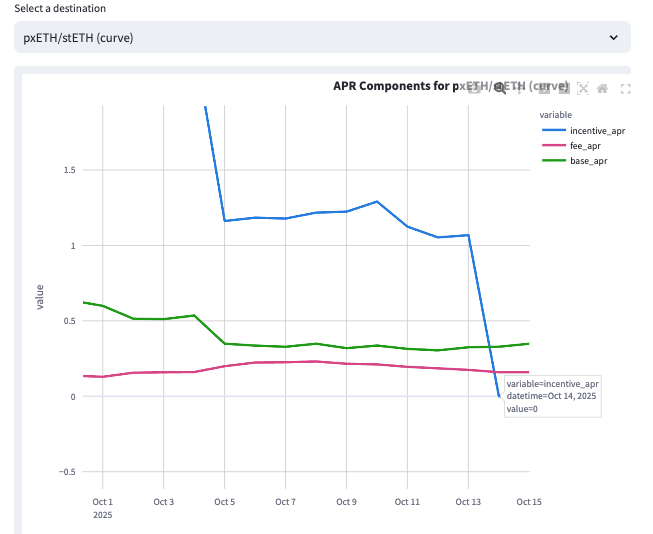

In [ ]:
# can I manually check if rewards are claimable?

In [ ]:
didnt_have_expected_liquidation

In [ ]:
destinations[destinations["destination_vault_address"].isin(didnt_have_expected_liquidation)]

In [ ]:
destination_states[destination_states["destination_vault_address"].isin(didnt_have_expected_liquidation)]

In [ ]:
owned_shares_by_destination = (
    autopool_destination_states[["destination_vault_address", "owned_shares"]]
    .groupby("destination_vault_address")
    .max()
    .reset_index()
)

In [ ]:
def get_list_of_suspect_destinations():
    # a suspect_destination is a destiantion
    # where, the owned shares in the last 3 days is > 1
    # and the incentive apr is > .5
    # and there have been no claim vault rewards in the last 3 days
    pass